In [ ]:
!pip install accelerate


# **Imports**

In [26]:
import torch
import pandas as pd
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from collections import Counter

#**Our pre-trines model**

In [ ]:
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)


# **Data preprocessing**

In [31]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=120):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        input_text = f"generate course title: {sample['Skills']} for {sample['Organization']}"
        target_text = sample['Title']

        # Tokenize input and target text
        input_ids = self.tokenizer.encode(input_text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors="pt")
        target_ids = self.tokenizer.encode(target_text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors="pt")

        # Ensure both input_ids and target_ids have the same shape
        input_ids = input_ids.squeeze(dim=0)  # Remove the batch dimension
        target_ids = target_ids.squeeze(dim=0)  # Remove the batch dimension

        return {"input_ids": input_ids, "labels": target_ids}

# **Loadin and splitting the data**




In [32]:
# Load data
data = pd.read_csv('/content/coursera_course_dataset_v2_no_null.csv')

# Split data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, eval_data = train_test_split(train_data, test_size=0.1, random_state=42)

train_data.reset_index(drop=True, inplace=True)
eval_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Define datasets
train_dataset = CustomDataset(train_data, tokenizer)
eval_dataset = CustomDataset(eval_data, tokenizer)
test_dataset = CustomDataset(test_data, tokenizer)


# **Training the model**

In [33]:

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./flan-t5-base-training",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=8,
    logging_steps=45,
    save_steps=1000,
    save_total_limit=2,
    predict_with_generate=True,
    evaluation_strategy="steps",
    learning_rate=1e-4,
    weight_decay=0.06,  # Add weight decay regularization
    dataloader_drop_last=True,  # Ensure the last incomplete batch is not dropped during training
)

# Define data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, label_pad_token_id=-100, pad_to_multiple_of=8)
# Define Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,

)

# Fine-tune the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss
45,9.270100,0.932510
90,0.584800,0.229814
135,0.261700,0.190841
180,0.201300,0.184567
225,0.183400,0.179016
270,0.166200,0.176940
315,0.164700,0.178592
360,0.148700,0.174631
405,0.137100,0.175515
450,0.136700,0.173769


TrainOutput(global_step=630, training_loss=0.8395201561942933, metrics={'train_runtime': 374.4802, 'train_samples_per_second': 13.459, 'train_steps_per_second': 1.682, 'total_flos': 808869622579200.0, 'train_loss': 0.8395201561942933, 'epoch': 10.0})

# ***Saving the model into the drive***
this is how we save the model into the drive but we agreed wiht you to submit it without the saved model

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# model_path = "/content/drive/MyDrive/flan-t5-model"
# tokenizer_path = "/content/drive/MyDrive/flan-t5-tokenizer"

# model.save_pretrained(model_path)
# tokenizer.save_pretrained(tokenizer_path)

# **Saving the losses from the trained model**

In [34]:
# Train the model
train_losses = []
eval_losses = []

for step in range(4,28,1):


    print(trainer.state.log_history[step])
    if step % 2 == 1:
       # Evaluate the model on the validation dataset
      eval_loss = trainer.state.log_history[step]['eval_loss']
      print(f"Epoch {step}: Eval Loss = {eval_loss}")
      eval_losses.append(eval_loss)
    else:
      train_loss = trainer.state.log_history[step]['loss']

      train_losses.append(train_loss)


# Calculate the x-axis values for train and eval losses
train_epochs = [45 * (i + 1) for i in range(len(train_losses))]
eval_epochs = [45 * (i + 1) for i in range(len(eval_losses))]

{'loss': 0.2617, 'grad_norm': 0.3667222857475281, 'learning_rate': 7.857142857142858e-05, 'epoch': 2.14, 'step': 135}
{'eval_loss': 0.19084112346172333, 'eval_runtime': 1.1361, 'eval_samples_per_second': 49.292, 'eval_steps_per_second': 6.162, 'epoch': 2.14, 'step': 135}
Epoch 5: Eval Loss = 0.19084112346172333
{'loss': 0.2013, 'grad_norm': 0.32166987657546997, 'learning_rate': 7.142857142857143e-05, 'epoch': 2.86, 'step': 180}
{'eval_loss': 0.18456700444221497, 'eval_runtime': 1.1503, 'eval_samples_per_second': 48.683, 'eval_steps_per_second': 6.085, 'epoch': 2.86, 'step': 180}
Epoch 7: Eval Loss = 0.18456700444221497
{'loss': 0.1834, 'grad_norm': 0.4912629723548889, 'learning_rate': 6.428571428571429e-05, 'epoch': 3.57, 'step': 225}
{'eval_loss': 0.17901645600795746, 'eval_runtime': 1.1423, 'eval_samples_per_second': 49.024, 'eval_steps_per_second': 6.128, 'epoch': 3.57, 'step': 225}
Epoch 9: Eval Loss = 0.17901645600795746
{'loss': 0.1662, 'grad_norm': 0.3988872170448303, 'learning_

# **Training loss**

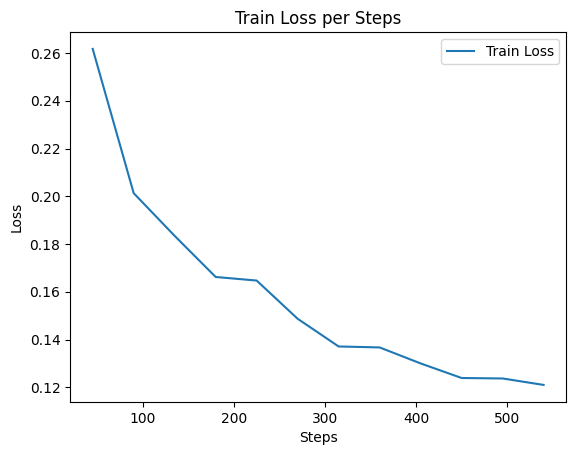

In [35]:

plt.plot(train_epochs, train_losses, label="Train Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Train Loss per Steps")
plt.legend()
plt.show()

# **Validation Loss**

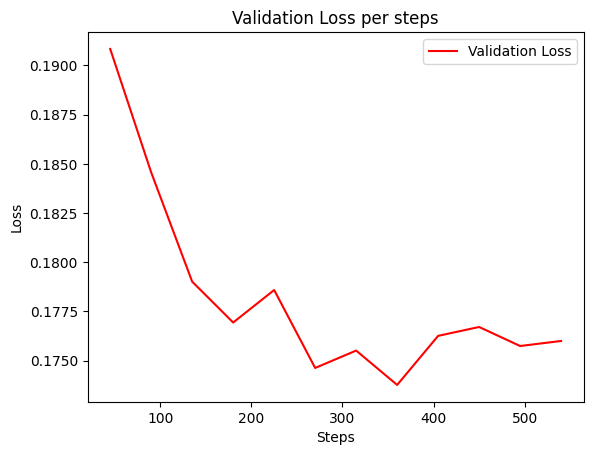

In [36]:
plt.plot(eval_epochs, eval_losses, label="Validation Loss", color="red")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Validation Loss per steps")
plt.legend()
plt.show()

# **Test the model**

In [40]:
eval_dataloader = DataLoader(test_dataset, batch_size=1)
def evaluate_model_with_nucleus_sampling(model, tokenizer, eval_dataloader, device,max_length):
    # Set model to evaluation mode
    model.eval()
    num_correct = 0
    total_loss = 0.0
    loss_fn = torch.nn.CrossEntropyLoss()
    repeated_generations = Counter()

    # Iterate over validation dataset and generate predictions
    for batch in eval_dataloader:
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        # Generate predictions using nucleus sampling
        with torch.no_grad():
            output = model.generate(
                input_ids=input_ids,
                length_penalty=0.9,
                num_beams=1,
                early_stopping=True,
                # no_repeat_ngram_size=2,
                max_length=max_length,
                do_sample=True,
                temperature=0.9,  # Adjust temperature if necessary
                top_k=120,
                top_p=0.85,  # Set nucleus probability
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                repetition_penalty=2.1,
            )

        # Decode predictions and labels
        decoded_preds = tokenizer.decode(output[0], skip_special_tokens=True)
        decoded_labels = tokenizer.decode(labels[0], skip_special_tokens=True)

        if decoded_preds == decoded_labels:
            num_correct += 1

        # Calculate loss
        outputs = model(input_ids, labels=labels)
        logits = outputs.logits
        loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
        total_loss += loss.item()
        repeated_generations[decoded_preds] += 1

        # Print predictions and labels
        print("Prediction:", decoded_preds)
        print("Label:", decoded_labels)
        print("Loss:", loss.item())
        print()

    # Calculate accuracy
    accuracy = num_correct / len(eval_dataloader)
    average_loss = total_loss / len(eval_dataloader)
    print("Number of correct predictions:", num_correct)
    print("Accuracy:", accuracy)
    print("Average Loss:", average_loss)

    print("Repeated Generations:")
    for generation, count in repeated_generations.items():
        if count > 1:
            print(f"Generation: {generation}, Count: {count}")

# Set nucleus sampling probability and maximum sequence length

max_length = 20

# Call the function to evaluate the model with nucleus sampling
evaluate_model_with_nucleus_sampling(model, tokenizer, eval_dataloader, device, max_length)

Prediction: Java Programming
Label: Object Oriented Programming in Java
Loss: 0.1328035593032837

Prediction: FinTech, AI and Machine Learning: Foundations
Label: Application of AI, InsurTech, and Real Estate Technology
Loss: 0.4365856349468231

Prediction: Human Resources and Organizational Change
Label: Leading People and Teams
Loss: 0.1440632939338684

Prediction: Graphic Design - With Autodesk
Label: Autodesk Certified Professional: AutoCAD for Design and Drafting Exam Prep
Loss: 0.4945387840270996

Prediction: Google Cloud Security
Label: Preparing for Google Cloud Certification: Cloud Security Engineer
Loss: 0.06914714723825455

Prediction: Creative Writing
Label: The Singer Songwriter
Loss: 0.2101302593946457

Prediction: Meta Front-End Developer
Label: Introduction to Front-End Development
Loss: 0.11276285350322723

Prediction: Digital Marketing
Label: The Strategy of Content Marketing
Loss: 0.1725379377603531

Prediction: TensorFlow, Machine Learning and Graphics
Label: Tensor

# **Manual title generation**

In [41]:
# Check if CUDA is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


# Function to generate course title
def generate_course_title(skills, organization):
    input_text = f"generate course title: {skills} for {organization}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=100, truncation=True)
    input_ids = input_ids.to(device)  # Move input to the same device as the model
    output = model.generate(
                    input_ids=input_ids,
                    length_penalty=0.6,
                    no_repeat_ngram_size=2,
                    max_length=max_length,
                    do_sample=True,
                    temperature=0.7,  # Adjust temperature if necessary
                    top_k=150,
                    top_p=0.85,  # Set nucleus probability
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                    repetition_penalty=2.1,
                )
    output_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return output_text


# Create input widgets
organization_input = widgets.Text(description="Organization:", placeholder="Enter organization")
skills_input = widgets.Text(description="Skills:", placeholder="Enter skills", layout=widgets.Layout(width='50%', height='40px', font_size='16px'))
generate_button = widgets.Button(description="Generate")

# Function to handle button click event
def on_generate_button_click(b):
    skills = skills_input.value.strip()
    organization = organization_input.value.strip()
    if skills and organization:
        generated_title = generate_course_title(skills, organization)
        output_text.value = f"Generated Course Title: {generated_title}"
    else:
        output_text.value = "Please enter both skills and organization."

# Attach button click event
generate_button.on_click(on_generate_button_click)

# Create output widget
output_text = widgets.HTML()

# Arrange widgets
ui = widgets.VBox([skills_input, organization_input, generate_button, output_text])

# Display the UI
display(ui)